# Semana 2: Reproducción del baseline

## 0.5 Preprocesar los datos



In [1]:
# Celda 0.5: Preprocesar los datos

from pathlib import Path
import pandas as pd
from sklearn.preprocessing import StandardScaler

# 1) Cargar características
csv_path = Path("../data/ecg_features.csv")
df = pd.read_csv(csv_path)

# 2) Eliminar outliers: recortar cada feature al percentil 1 y 99
cols = ['media_mv','mstd_mV','skewness','kurtosis','rr_mean_s','rr_std_s']
for col in cols:
    p1, p99 = df[col].quantile([0.01, 0.99])
    df[col] = df[col].clip(p1, p99)

# 3) Separar X e y
X = df[cols]
y = df['label']

# 4) Estandarizar con media 0 y varianza 1
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 5) DataFrame procesado
df_pre = pd.DataFrame(X_scaled, columns=cols)
df_pre['label'] = y.values

print("Datos preprocesados:", df_pre.shape)
display(df_pre.head())

Datos preprocesados: (60, 7)


,media_mv,mstd_mV,skewness,kurtosis,rr_mean_s,rr_std_s,label
0,0.190851,-0.194293,0.272044,-0.391961,0.119495,-0.990627,Normal
1,0.887660,-0.563532,1.405858,1.610971,0.926851,0.985682,Normal
2,-0.123761,-0.854334,-1.549949,-0.187959,-0.017798,-0.960585,Normal
3,2.550252,0.047609,1.244108,0.108750,1.627454,0.303252,AFib
4,0.095630,0.049088,0.386649,-0.444615,-1.225096,0.917802,AFib


## 1. Entrenar un modelo base



In [19]:

# Celda 1: Entrenar un modelo base (SVM) con los datos ya preprocesados

from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

# 1) Cargar X e y desde df_pre (preprocesado en la celda 0.5)
X = df_pre[cols]
y = df_pre['label']

# 2) División train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

# 3) Entrenamiento
model = SVC(kernel='rbf', probability=True, random_state=42)
model.fit(X_train, y_train)

print(f"Entrenado SVM con {X_train.shape[0]} muestras preprocesadas.")

Entrenado SVM con 42 muestras preprocesadas.


## 2. Evaluar el desempeño del modelo

Accuracy:  0.778
Precision: 0.727
Recall:    0.889
F1-score:  0.800


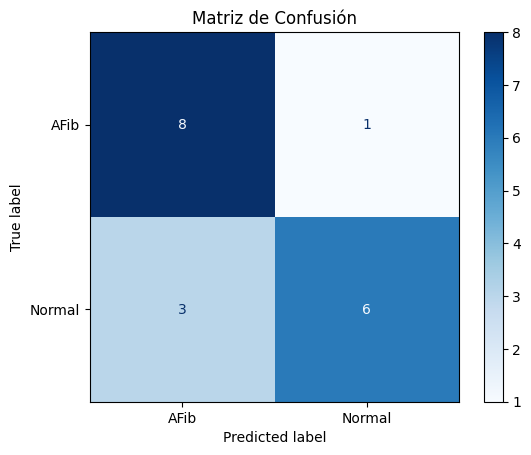

In [20]:
# 2. Evaluación del modelo
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, ConfusionMatrixDisplay
)
import matplotlib.pyplot as plt

# Predicción
y_pred = model.predict(X_test)

# Cálculo de métricas (AFib como positiva)
acc   = accuracy_score(y_test, y_pred)
prec  = precision_score(y_test, y_pred, pos_label='AFib')
rec   = recall_score(y_test, y_pred, pos_label='AFib')
f1    = f1_score(y_test, y_pred, pos_label='AFib')

print(f"Accuracy:  {acc:.3f}")
print(f"Precision: {prec:.3f}")
print(f"Recall:    {rec:.3f}")
print(f"F1-score:  {f1:.3f}")

# Matriz de confusión
disp = ConfusionMatrixDisplay.from_estimator(
    model, X_test, y_test, display_labels=model.classes_, cmap=plt.cm.Blues
)
disp.ax_.set_title("Matriz de Confusión")
plt.show()


## 3. Análisis breve

- Accuracy: 14/18 ≈ 0.78  
- Recall (AFib como positiva): 8/9 ≈ 0.89  
- Precision (AFib como positiva): 8/11 ≈ 0.73  
- Falsos negativos (AFib → Normal): 1  
- Falsos positivos (Normal → AFib): 3  
